In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

* # CARGA Y ANÁLISIS EXPLORATORIO DE LAS IMÁGENES.
* Imagenes sobre patentes de algunos paises diferentes

In [94]:
import os

In [95]:
### Ubicacion de la carpeta
data_dir = "./matriculas/" 

In [96]:
#### Obtener una lista de las subcarpetas en la carpeta 'matricula'
subfolders = [f.path for f in os.scandir(data_dir) if f.is_dir()]

In [97]:
### Vemos cuales tenemos
subfolders

['./matriculas/Brazil',
 './matriculas/Estonia',
 './matriculas/Finland',
 './matriculas/Kazakhstan',
 './matriculas/Lithuania',
 './matriculas/Serbia',
 './matriculas/UAE']

* Nombre de las carpetas que contiene diferentes imágenes 
----

In [98]:
#### Crear un diccionario para almacenar el recuento de imágenes por subcarpeta
image_counts = {}

In [99]:
#### Recorrer cada subcarpeta y contar la cantidad de imágenes
for folder in subfolders:
    folder_name = os.path.basename(folder)
    image_files = [f for f in os.listdir(folder) if f.endswith(".jpg") or f.endswith(".png")]
    image_counts[folder_name] = len(image_files)

In [100]:
#### Indicar el recuento por subcarpetas
for folder, count in image_counts.items():
    print(f"{folder}: {count} imágenes")

Brazil: 20 imágenes
Estonia: 20 imágenes
Finland: 20 imágenes
Kazakhstan: 40 imágenes
Lithuania: 20 imágenes
Serbia: 40 imágenes
UAE: 40 imágenes


* Nombres de las carpetas (los nombres son los paises en el cual se encuentra cada patente)
* Cantidad de imagenes que contienen cada carpeta
----

In [101]:
# Visualizar algunas muestras de imágenes
sample_folder = subfolders[0]  # Tomamos la primera subcarpeta como ejemplo
sample_images = [os.path.join(sample_folder, f) for f in os.listdir(sample_folder) if f.endswith(".jpg") or f.endswith(".png")]

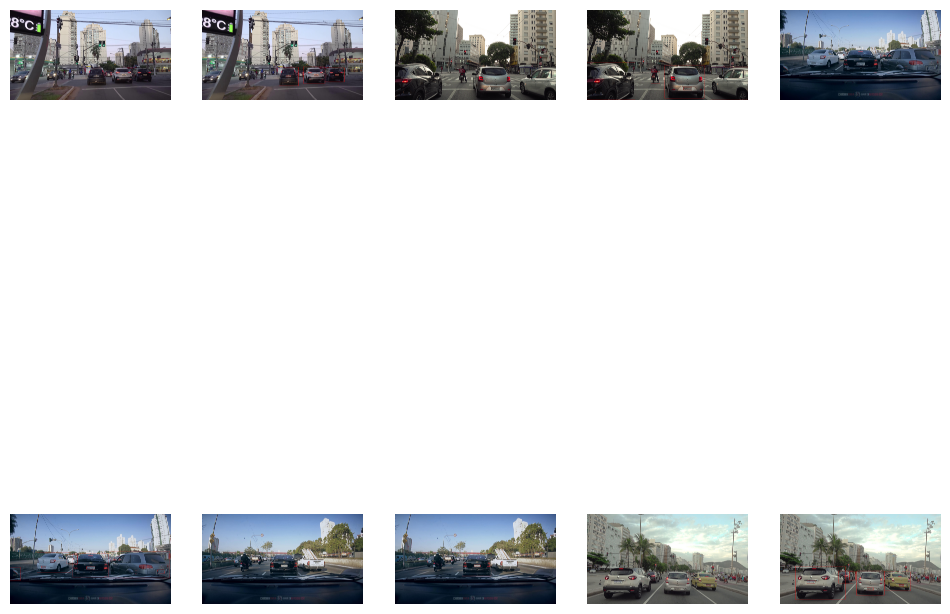

In [102]:
plt.figure(figsize=(12, 12))
for i, image_path in enumerate(sample_images[:10]):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.subplot(2, 5, i + 1)
    plt.imshow(image)
    plt.axis('off')

plt.show()


* ### Podemos observar que cada imágenes contienen mas de 2 patentes (es decir hay mas de 2 autos)
* ### Por lo visto también al ser patentes de diferentes paises, cambian su formatos y cantidad de numeros en cada patente
----

-----
* # REDIMENSIONAR LAS IMÁGENES 

In [103]:
#### Tamaño de imagen deseada, Hacemos 150x150 por que no tengo una muy buena placa de video y exprimir al maximo 
#### Luego seguiremos intentando subiendo las escalas y ver si mi PC esta optima 
image_size = (150, 150)

In [104]:
####FUNCION - redimensionar las imágenes
def resize_image(image_path, target_size):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    resized_image = cv2.resize(image, target_size)
    return resized_image

In [105]:
#### SELECCIONAR todas las imágenes en las subcarpetas
resized_images = []
for folder in subfolders:
    image_files = [f for f in os.listdir(folder) if f.endswith(".jpg") or f.endswith(".png")]
    for file in image_files:
        image_path = os.path.join(folder, file)
        resized_image = resize_image(image_path, image_size)
        resized_images.append(resized_image)

In [106]:
##### La lista de imágenes redimensionadas pasadas a un array
resized_images = np.array(resized_images)

In [107]:
import tensorflow as tf
from tensorflow.keras import layers, models

-----
* # CONSTRUCCIÓN MODELO PARA RECONOCER LAS IMAGENES
    * ### Dividir los datos en conjuntos de entrenamiento, validación y prueba

---
* # Primero importamos algunas imagenes de manera random para ver como estan compuestas cada una de ellas.

In [108]:
#### Las etiquetas de las subcarpetas
labels = list(image_counts.keys())

In [109]:
### Almacenamos las imágenes y etiquetas
images = []
image_labels = []

In [110]:
import random
figuras_random = random.sample(range(0,len(labels)),4)
figuras_random

[6, 2, 1, 5]

In [111]:
#### Recorrer cada subcarpeta y asignar etiquetas a las imágenes
for folder in subfolders:
    image_files = [f for f in os.listdir(folder) if f.endswith(".jpg") or f.endswith(".png")]
    for file in image_files:
        image_path = os.path.join(folder, file)
        resized_image = resize_image(image_path, image_size)
        images.append(resized_image)
        image_labels.append(labels.index(os.path.basename(folder)))

In [112]:
### Convertir las listas de imágenes y etiquetas a array
images = np.array(images)
image_labels = np.array(image_labels)

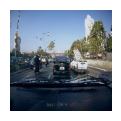

Forma:(150, 150, 3), min:0, max:250


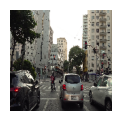

Forma:(150, 150, 3), min:0, max:255


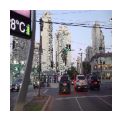

Forma:(150, 150, 3), min:0, max:255


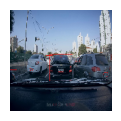

Forma:(150, 150, 3), min:0, max:245


In [113]:
### Creamos un bucle para que nos imprima las 4 imagenes seleccionas aleatoriamente y ver como estan compuestas
for i in range(len(figuras_random)):
    im_temporal = images[figuras_random[i]]
    plt.subplot(1,4,i+1)
    plt.axis("off")
    plt.imshow(images[figuras_random[i]])
    plt.subplots_adjust(wspace=0.3)
    plt.show()
    print("Forma:{0}, min:{1}, max:{2}".format(im_temporal.shape,im_temporal.min(),im_temporal.max()))

* **Observaciónes**

    * Se pueden observar que son imagenes de la misma calidad y tamaño (es por que al principio le indicamos la cantidad de pixeles a tener en cuenta).
    * Forma (altura, ancho, canales de colores usados).
    * Min (minimo color de pixel usado).
    * Max (Maximo color de pixel usado).

----
* # Dividir los datos en conjuntos de entrenamiento, validación y prueba

In [114]:
train_ratio = 0.7  #### entrenamiento
val_ratio = 0.15  #### para validación
test_ratio = 0.15  ####datos para prueba

In [115]:
num_samples = len(images)
num_train = int(train_ratio * num_samples)
num_val = int(val_ratio * num_samples)

In [116]:
#### Mezclamos los datos aleatoriamente
random_indices = np.random.permutation(num_samples)
images = images[random_indices]
image_labels = image_labels[random_indices]

In [117]:
#### DIVIDIMOS los datos
train_images = images[:num_train]
train_labels = image_labels[:num_train]
val_images = images[num_train:num_train+num_val]
val_labels = image_labels[num_train:num_train+num_val]
test_images = images[num_train+num_val:]
test_labels = image_labels[num_train+num_val:]

* # Definimos la arquitectura de la red neuronal

In [143]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(len(labels), activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 82944)             0         
                                                                 
 dense_4 (Dense)             (None, 64)               

In [150]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

epochs = 4  # Número de épocas de entrenamiento

history = model.fit(train_images, train_labels, epochs=epochs, validation_data=(val_images, val_labels))

Epoch 1/4
5/5 [==============================] - 6s 898ms/step - loss: 0.0482 - accuracy: 0.9929 - val_loss: 31.2465 - val_accuracy: 0.5667
Epoch 2/4
5/5 [==============================] - 3s 678ms/step - loss: 0.2354 - accuracy: 0.9857 - val_loss: 19.1913 - val_accuracy: 0.6333
Epoch 3/4
5/5 [==============================] - 3s 683ms/step - loss: 0.0546 - accuracy: 0.9857 - val_loss: 19.5374 - val_accuracy: 0.6333
Epoch 4/4
5/5 [==============================] - 5s 929ms/step - loss: 0.1908 - accuracy: 0.9929 - val_loss: 10.2646 - val_accuracy: 0.6667


In [151]:
#### Vemos y evaluamos el modelo
test_loss, test_accuracy = model.evaluate(test_images, test_labels)

print(f"Loss: {test_loss}")
print(f"Accuracy: {test_accuracy}")

1/1 [==============================] - 0s 281ms/step - loss: 4.7884 - accuracy: 0.7667
Loss: 4.788386821746826
Accuracy: 0.7666666507720947


* # Vemos que el modelo es bastante bueno, tiene una eficacia de %83.33 en reconocer las patente de autos
----

----
* # EVALUACIÓN DE LA RED NEURONAL
    * ### Vemos una por una de las primeras diez, asi se entienden mejor las imágenes

In [126]:
# Seleccionar una imagen para la predicción (por ejemplo, la primera imagen de prueba)
image = test_images[0]
label = test_labels[0]

In [127]:
### Preprocesar la imagen
preprocessed_image = np.expand_dims(image, axis=0)

#### Realizar la predicción en la imagen
prediction = model.predict(preprocessed_image)[0]
predicted_label = np.argmax(prediction)

1/1 [==============================] - 0s 178ms/step


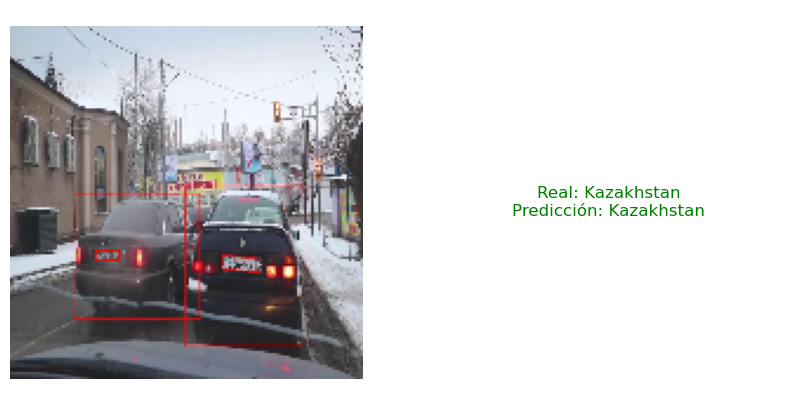

In [128]:
#### Definir la etiqueta real y predicha
true_label = labels[label]
predicted_label = labels[predicted_label]

#### Crear la figura y los subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

#### Mostramo la imagen
ax1.imshow(image)
ax1.axis('off')

#### Mostrar las etiquetas real y predicha
color = "green" if true_label == predicted_label else "red"
ax2.text(0.5, 0.5, f"Real: {true_label}\nPredicción: {predicted_label}",
         fontsize=12, color=color, ha='center', va='center')
ax2.axis('off')

plt.show()

* Vemos que esta imágen la predijo bien
----

In [129]:
image = test_images[1]
label = test_labels[1]

### Preprocesar la imagen
preprocessed_image = np.expand_dims(image, axis=0)

#### Realizar la predicción en la imagen
prediction = model.predict(preprocessed_image)[0]
predicted_label = np.argmax(prediction)

1/1 [==============================] - 0s 64ms/step


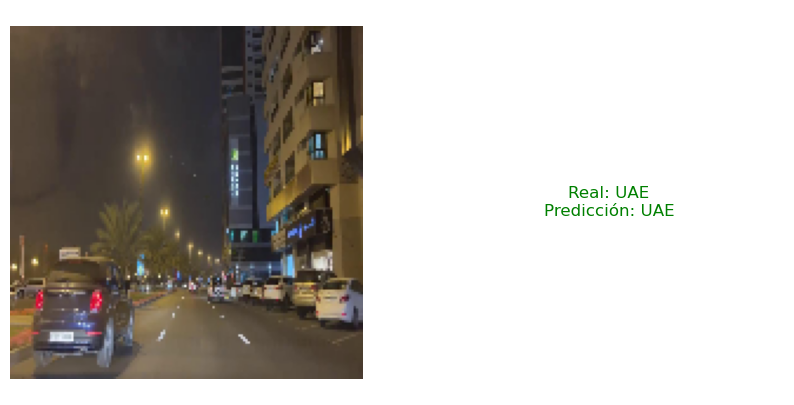

In [130]:
# Definir la etiqueta real y predicha
true_label = labels[label]
predicted_label = labels[predicted_label]

# Crear la figura y los subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Mostrar la imagen
ax1.imshow(image)
ax1.axis('off')

# Mostrar las etiquetas real y predicha
color = "green" if true_label == predicted_label else "red"
ax2.text(0.5, 0.5, f"Real: {true_label}\nPredicción: {predicted_label}",
         fontsize=12, color=color, ha='center', va='center')
ax2.axis('off')

plt.show()

* Vemos que también esta fue una predicción buena
----

1/1 [==============================] - 0s 40ms/step


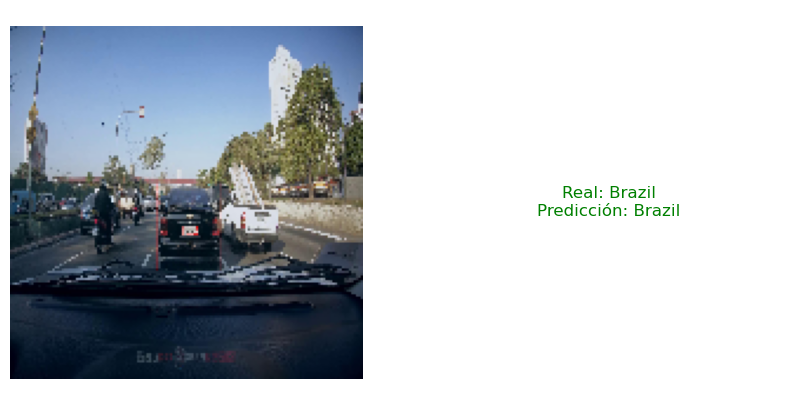

In [132]:
image = test_images[2]
label = test_labels[2]

### Preprocesar la imagen
preprocessed_image = np.expand_dims(image, axis=0)

#### Realizar la predicción en la imagen
prediction = model.predict(preprocessed_image)[0]
predicted_label = np.argmax(prediction)

################################################

#### Definir la etiqueta real y predicha
true_label = labels[label]
predicted_label = labels[predicted_label]

#### Crear la figura y los subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

#### Mostramo la imagen
ax1.imshow(image)
ax1.axis('off')

#### Mostrar las etiquetas real y predicha
color = "green" if true_label == predicted_label else "red"
ax2.text(0.5, 0.5, f"Real: {true_label}\nPredicción: {predicted_label}",
         fontsize=12, color=color, ha='center', va='center')
ax2.axis('off')

plt.show()

In [135]:
* Vemos que también esta fue una predicción buena
----

SyntaxError: invalid syntax (1326722480.py, line 1)

1/1 [==============================] - 0s 45ms/step


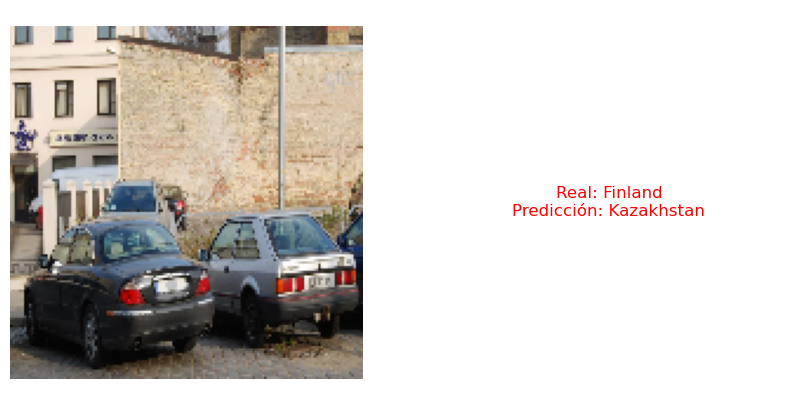

In [134]:
image = test_images[3]
label = test_labels[3]

### Preprocesar la imagen
preprocessed_image = np.expand_dims(image, axis=0)

#### Realizar la predicción en la imagen
prediction = model.predict(preprocessed_image)[0]
predicted_label = np.argmax(prediction)

################################################

#### Definir la etiqueta real y predicha
true_label = labels[label]
predicted_label = labels[predicted_label]

#### Crear la figura y los subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

#### Mostramo la imagen
ax1.imshow(image)
ax1.axis('off')

#### Mostrar las etiquetas real y predicha
color = "green" if true_label == predicted_label else "red"
ax2.text(0.5, 0.5, f"Real: {true_label}\nPredicción: {predicted_label}",
         fontsize=12, color=color, ha='center', va='center')
ax2.axis('off')

plt.show()

* Vemos que esta fue una predicción mal - Era de Finlandia y predijo que eran de kazakhstan
----

1/1 [==============================] - 0s 51ms/step


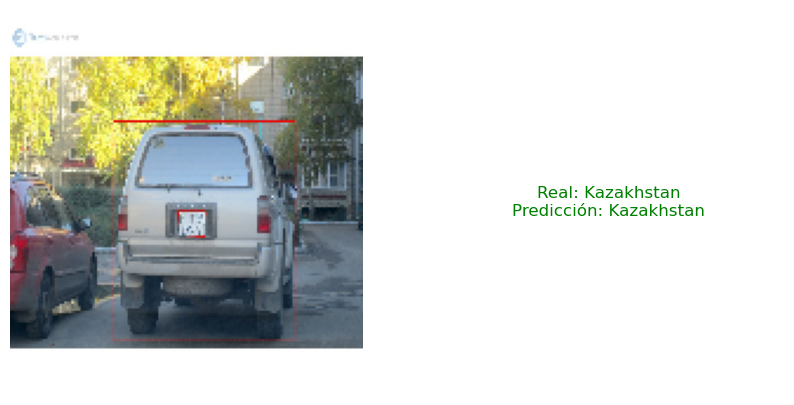

In [136]:
image = test_images[4]
label = test_labels[4]

### Preprocesar la imagen
preprocessed_image = np.expand_dims(image, axis=0)

#### Realizar la predicción en la imagen
prediction = model.predict(preprocessed_image)[0]
predicted_label = np.argmax(prediction)

################################################

#### Definir la etiqueta real y predicha
true_label = labels[label]
predicted_label = labels[predicted_label]

#### Crear la figura y los subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

#### Mostramo la imagen
ax1.imshow(image)
ax1.axis('off')

#### Mostrar las etiquetas real y predicha
color = "green" if true_label == predicted_label else "red"
ax2.text(0.5, 0.5, f"Real: {true_label}\nPredicción: {predicted_label}",
         fontsize=12, color=color, ha='center', va='center')
ax2.axis('off')

plt.show()

* Predicción muy buena también 
----

1/1 [==============================] - 0s 40ms/step


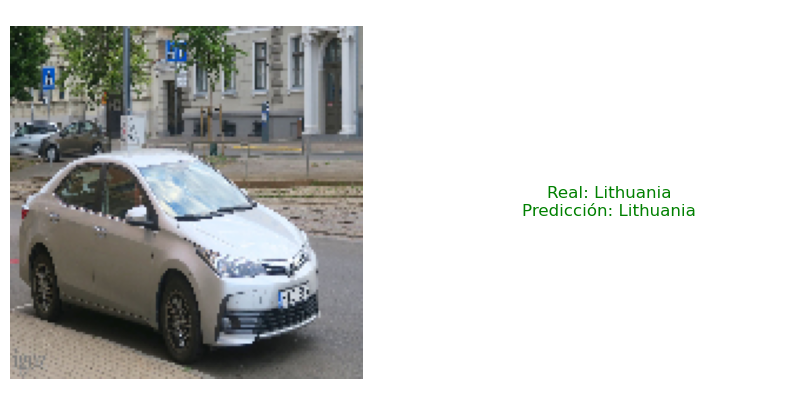

In [137]:
image = test_images[5]
label = test_labels[5]

### Preprocesar la imagen
preprocessed_image = np.expand_dims(image, axis=0)

#### Realizar la predicción en la imagen
prediction = model.predict(preprocessed_image)[0]
predicted_label = np.argmax(prediction)

################################################

#### Definir la etiqueta real y predicha
true_label = labels[label]
predicted_label = labels[predicted_label]

#### Crear la figura y los subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

#### Mostramo la imagen
ax1.imshow(image)
ax1.axis('off')

#### Mostrar las etiquetas real y predicha
color = "green" if true_label == predicted_label else "red"
ax2.text(0.5, 0.5, f"Real: {true_label}\nPredicción: {predicted_label}",
         fontsize=12, color=color, ha='center', va='center')
ax2.axis('off')

plt.show()

1/1 [==============================] - 0s 34ms/step


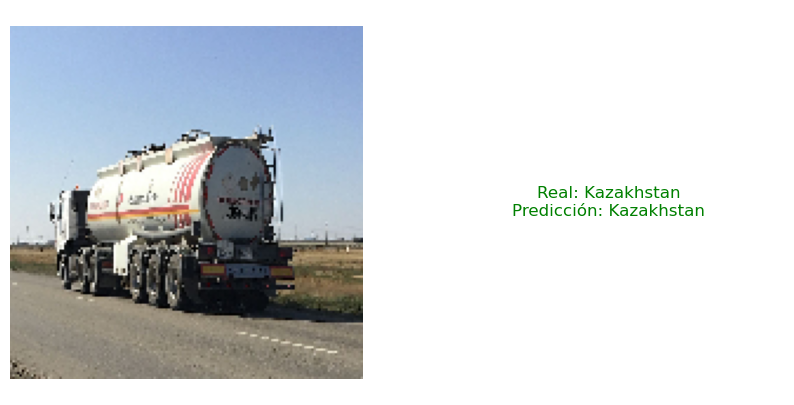

In [138]:
image = test_images[6]
label = test_labels[6]

### Preprocesar la imagen
preprocessed_image = np.expand_dims(image, axis=0)

#### Realizar la predicción en la imagen
prediction = model.predict(preprocessed_image)[0]
predicted_label = np.argmax(prediction)

################################################

#### Definir la etiqueta real y predicha
true_label = labels[label]
predicted_label = labels[predicted_label]

#### Crear la figura y los subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

#### Mostramo la imagen
ax1.imshow(image)
ax1.axis('off')

#### Mostrar las etiquetas real y predicha
color = "green" if true_label == predicted_label else "red"
ax2.text(0.5, 0.5, f"Real: {true_label}\nPredicción: {predicted_label}",
         fontsize=12, color=color, ha='center', va='center')
ax2.axis('off')

plt.show()

1/1 [==============================] - 0s 52ms/step


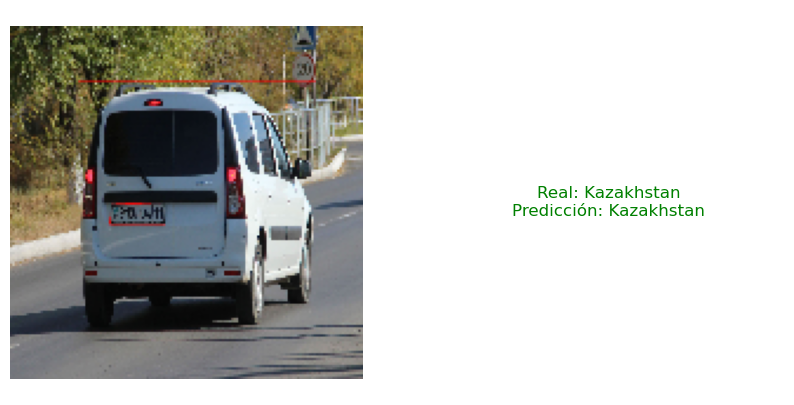

In [139]:
image = test_images[7]
label = test_labels[7]

### Preprocesar la imagen
preprocessed_image = np.expand_dims(image, axis=0)

#### Realizar la predicción en la imagen
prediction = model.predict(preprocessed_image)[0]
predicted_label = np.argmax(prediction)

################################################

#### Definir la etiqueta real y predicha
true_label = labels[label]
predicted_label = labels[predicted_label]

#### Crear la figura y los subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

#### Mostramo la imagen
ax1.imshow(image)
ax1.axis('off')

#### Mostrar las etiquetas real y predicha
color = "green" if true_label == predicted_label else "red"
ax2.text(0.5, 0.5, f"Real: {true_label}\nPredicción: {predicted_label}",
         fontsize=12, color=color, ha='center', va='center')
ax2.axis('off')

plt.show()

1/1 [==============================] - 0s 39ms/step


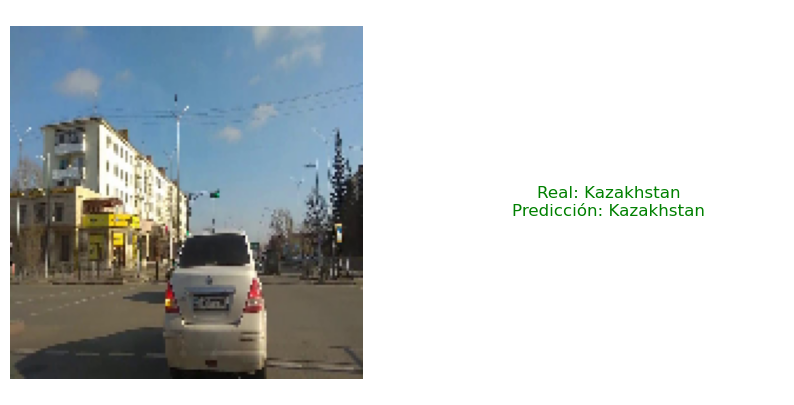

In [140]:
image = test_images[8]
label = test_labels[8]

### Preprocesar la imagen
preprocessed_image = np.expand_dims(image, axis=0)

#### Realizar la predicción en la imagen
prediction = model.predict(preprocessed_image)[0]
predicted_label = np.argmax(prediction)

################################################

#### Definir la etiqueta real y predicha
true_label = labels[label]
predicted_label = labels[predicted_label]

#### Crear la figura y los subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

#### Mostramo la imagen
ax1.imshow(image)
ax1.axis('off')

#### Mostrar las etiquetas real y predicha
color = "green" if true_label == predicted_label else "red"
ax2.text(0.5, 0.5, f"Real: {true_label}\nPredicción: {predicted_label}",
         fontsize=12, color=color, ha='center', va='center')
ax2.axis('off')

plt.show()

1/1 [==============================] - 0s 46ms/step


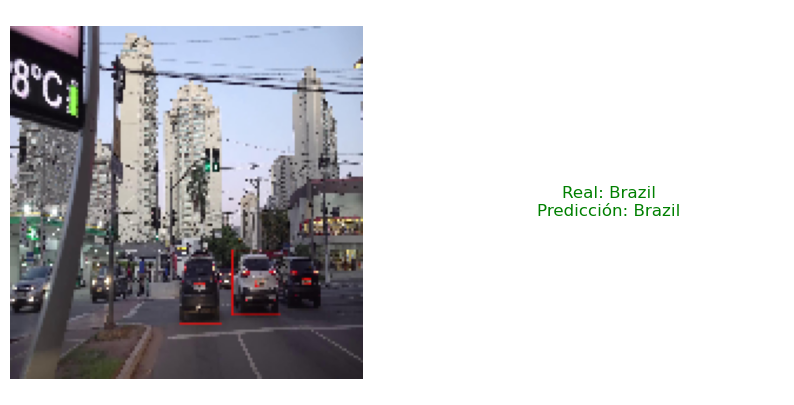

In [141]:
image = test_images[9]
label = test_labels[9]

### Preprocesar la imagen
preprocessed_image = np.expand_dims(image, axis=0)

#### Realizar la predicción en la imagen
prediction = model.predict(preprocessed_image)[0]
predicted_label = np.argmax(prediction)

################################################

#### Definir la etiqueta real y predicha
true_label = labels[label]
predicted_label = labels[predicted_label]

#### Crear la figura y los subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

#### Mostramo la imagen
ax1.imshow(image)
ax1.axis('off')

#### Mostrar las etiquetas real y predicha
color = "green" if true_label == predicted_label else "red"
ax2.text(0.5, 0.5, f"Real: {true_label}\nPredicción: {predicted_label}",
         fontsize=12, color=color, ha='center', va='center')
ax2.axis('off')

plt.show()

1/1 [==============================] - 0s 46ms/step


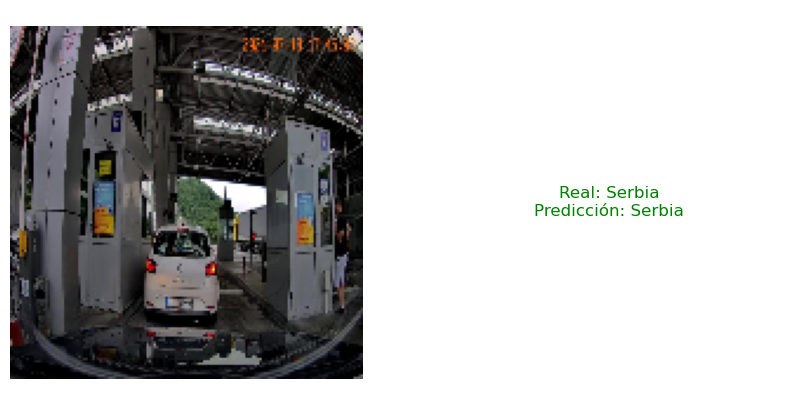

In [142]:
image = test_images[10]
label = test_labels[10]

### Preprocesar la imagen
preprocessed_image = np.expand_dims(image, axis=0)

#### Realizar la predicción en la imagen
prediction = model.predict(preprocessed_image)[0]
predicted_label = np.argmax(prediction)

################################################

#### Definir la etiqueta real y predicha
true_label = labels[label]
predicted_label = labels[predicted_label]

#### Crear la figura y los subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

#### Mostramo la imagen
ax1.imshow(image)
ax1.axis('off')

#### Mostrar las etiquetas real y predicha
color = "green" if true_label == predicted_label else "red"
ax2.text(0.5, 0.5, f"Real: {true_label}\nPredicción: {predicted_label}",
         fontsize=12, color=color, ha='center', va='center')
ax2.axis('off')

plt.show()

In [86]:
# Seleccionar varias imágenes para la predicción (por ejemplo, las primeras 10 imágenes de prueba)
num_images = 10
sample_images = test_images[:num_images]
sample_labels = test_labels[:num_images]

# Preprocesar las imágenes
preprocessed_images = np.array([np.expand_dims(image, axis=0) for image in sample_images])

# Realizar la predicción en las imágenes
predictions = model.predict(preprocessed_images)
predicted_labels = np.argmax(predictions, axis=1)

InvalidArgumentError: Graph execution error:

Detected at node 'sequential/conv2d/Relu' defined at (most recent call last):
    File "C:\Users\Acer\anaconda3\envs\Trabajar-con-tensorflow\lib\runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\Acer\anaconda3\envs\Trabajar-con-tensorflow\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\Acer\anaconda3\envs\Trabajar-con-tensorflow\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\Acer\anaconda3\envs\Trabajar-con-tensorflow\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\Acer\anaconda3\envs\Trabajar-con-tensorflow\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "C:\Users\Acer\anaconda3\envs\Trabajar-con-tensorflow\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\Acer\anaconda3\envs\Trabajar-con-tensorflow\lib\asyncio\base_events.py", line 570, in run_forever
      self._run_once()
    File "C:\Users\Acer\anaconda3\envs\Trabajar-con-tensorflow\lib\asyncio\base_events.py", line 1859, in _run_once
      handle._run()
    File "C:\Users\Acer\anaconda3\envs\Trabajar-con-tensorflow\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\Acer\anaconda3\envs\Trabajar-con-tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\Acer\anaconda3\envs\Trabajar-con-tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\Acer\anaconda3\envs\Trabajar-con-tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\Acer\anaconda3\envs\Trabajar-con-tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "C:\Users\Acer\anaconda3\envs\Trabajar-con-tensorflow\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "C:\Users\Acer\anaconda3\envs\Trabajar-con-tensorflow\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\Acer\anaconda3\envs\Trabajar-con-tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "C:\Users\Acer\anaconda3\envs\Trabajar-con-tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "C:\Users\Acer\anaconda3\envs\Trabajar-con-tensorflow\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\Acer\anaconda3\envs\Trabajar-con-tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\Acer\anaconda3\envs\Trabajar-con-tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\Acer\anaconda3\envs\Trabajar-con-tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Acer\AppData\Local\Temp\ipykernel_8488\975804644.py", line 2, in <cell line: 2>
      prediction = model.predict(preprocessed_images)
    File "C:\Users\Acer\anaconda3\envs\Trabajar-con-tensorflow\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Acer\anaconda3\envs\Trabajar-con-tensorflow\lib\site-packages\keras\engine\training.py", line 2347, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "C:\Users\Acer\anaconda3\envs\Trabajar-con-tensorflow\lib\site-packages\keras\engine\training.py", line 2134, in predict_function
      return step_function(self, iterator)
    File "C:\Users\Acer\anaconda3\envs\Trabajar-con-tensorflow\lib\site-packages\keras\engine\training.py", line 2120, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Acer\anaconda3\envs\Trabajar-con-tensorflow\lib\site-packages\keras\engine\training.py", line 2108, in run_step
      outputs = model.predict_step(data)
    File "C:\Users\Acer\anaconda3\envs\Trabajar-con-tensorflow\lib\site-packages\keras\engine\training.py", line 2076, in predict_step
      return self(x, training=False)
    File "C:\Users\Acer\anaconda3\envs\Trabajar-con-tensorflow\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Acer\anaconda3\envs\Trabajar-con-tensorflow\lib\site-packages\keras\engine\training.py", line 560, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\Acer\anaconda3\envs\Trabajar-con-tensorflow\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Acer\anaconda3\envs\Trabajar-con-tensorflow\lib\site-packages\keras\engine\base_layer.py", line 1107, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\Acer\anaconda3\envs\Trabajar-con-tensorflow\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Acer\anaconda3\envs\Trabajar-con-tensorflow\lib\site-packages\keras\engine\sequential.py", line 412, in call
      return super().call(inputs, training=training, mask=mask)
    File "C:\Users\Acer\anaconda3\envs\Trabajar-con-tensorflow\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\Acer\anaconda3\envs\Trabajar-con-tensorflow\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\Acer\anaconda3\envs\Trabajar-con-tensorflow\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Acer\anaconda3\envs\Trabajar-con-tensorflow\lib\site-packages\keras\engine\base_layer.py", line 1107, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\Acer\anaconda3\envs\Trabajar-con-tensorflow\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Acer\anaconda3\envs\Trabajar-con-tensorflow\lib\site-packages\keras\layers\convolutional\base_conv.py", line 314, in call
      return self.activation(outputs)
    File "C:\Users\Acer\anaconda3\envs\Trabajar-con-tensorflow\lib\site-packages\keras\activations.py", line 316, in relu
      return backend.relu(
    File "C:\Users\Acer\anaconda3\envs\Trabajar-con-tensorflow\lib\site-packages\keras\backend.py", line 5370, in relu
      x = tf.nn.relu(x)
Node: 'sequential/conv2d/Relu'
input must be 4-dimensional[10,1,150,150,3]
	 [[{{node sequential/conv2d/Relu}}]] [Op:__inference_predict_function_3295]